
## Fastai 3D images


### Resources

* https://towardsdatascience.com/working-with-3d-data-fastai2-5e2baa09037e 
* https://www.kaggle.com/jhoward/some-dicom-gotchas-to-be-aware-of-fastai
* https://forums.fast.ai/t/fastai-v2-has-a-medical-imaging-submodule/56117
* https://towardsdatascience.com/deep-learning-with-magnetic-resonance-and-computed-tomography-images-e9f32273dcb5

Fastai

* Pipelines and Transforms - https://docs.fast.ai/tutorial.pets
* Info on batch and item transforms - https://docs.fast.ai/vision.data#ImageDataLoaders
  - item transforms happen one item at a time on the CPU
  - batch transforms happen one batch at a time on the GPU
* Blocks tutorial - https://docs.fast.ai/tutorial.datablock.html
* Transform, ToTensor, TypeDispatch and a code walkthrough - https://forums.fast.ai/t/fastai-v2-code-walk-thru-5/54405/8?u=telarson
* Code Walkthroughs - https://forums.fast.ai/t/fastai-v2-daily-code-walk-thrus/53839
* Vision Transforms and Augmentations (including cropping) - https://docs.fast.ai/vision.augment
* Lesson 9 - Callbacks, DataBunches, Decorators, Datasets - https://forums.fast.ai/t/lesson-9-discussion-wiki-2019/41969
* https://course19.fast.ai/videos/?lesson=10, https://forums.fast.ai/t/lesson-10-discussion-wiki-2019/42781 - Navigating source code, BatchNorm and LayerNorm
* https://course19.fast.ai/videos/?lesson=11 - DataBlocks API. processing files efficiently
* https://course19.fast.ai/videos/?lesson=12 - Label Smoothing, NLP, UMLFit.

Pytorch

* https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Note that Fastai defaults to DICOM and doesn't appear to support NIFTI. 

### Notes

* Most of your types Blocks extend or compose TransformBlock.  They just call type, item and batch transforms.
* Pipelines would call a bunch of transforms at one time. 
* Transforms seem to be the key thing. consider writing these correctly first.
* Once you have the transforms you can figure out if you want to use a TfmsList or Dataset or DataBlock. 
* Consider inheriting from "ItemTransform". Can you see if you can get your to batch to "show" by writing "decode"?


In [1]:
from fastai.data.all import *
from fastai.vision.all import *
import os.path

In [2]:
%load_ext autoreload
%autoreload 2

from utils import *



In [3]:
import fastai

In [4]:
from IPython.core.debugger import set_trace


##### Write a DataBlock. 

It will give you back a Dataset and DataLoader


To build a DataBlock you need to give the library four things: 
 
* the types of your input/labels, and at least two functions: `get_items` and `splitter`. 
* You may also need to include `get_x` and `get_y` or a more generic list of getters that are applied to the results of get_items.



In [5]:
#what is the format of get_items? 

In [7]:
#https://docs.fast.ai/data.transforms.html#get_files
files = get_files('./data/small/t1', extensions='.gz', recurse=False)

In [8]:
files[0]

Path('data/small/t1/IXI167-HH-1569-T1_fcm.nii.gz')

In [9]:
type(files)

fastcore.foundation.L

From the first link in the resource section:

> remember from the DataBlock example above that get_x and get_y receive the output from get_items and should separate what is the input and what is the target. In this case, they are as simple as this:

In [130]:
from typing import Tuple


class NiftiGetItems():

    def __init__(self):
        pass
        
    def __call__(self, source_dir):
        
        #TODO: could just take the parent directory
        t1_files = os.listdir(source_dir)

        subj_list = [ path_to_subj(e) for e in t1_files if fnmatch(e, r'*T1_fcm.nii.gz') ] 
        
        out = [] 
        
        for s in subj_list:
            t1 = load_mr_image(s, "t1")
            t2 = load_mr_image(s, "t2")           
            out.append({'source': t1, 'target': t2})

        return out

class ShowNiftiSlice:
    def __init__(self, arr, slice_num=45):
        self.img_arr = arr[:,:, slice_num]
        
    def show(self, **kwargs): show_image(self.img_arr, **kwargs)

class NiftiTfm(ItemTransform):
    '''
    Take a set of items which are file names in setups
    Take a single file name in encodes, return a tuple with (src, target) both of which are numpy arrays. 
    Take (s:np.ndarray, t:np.ndarray) in decodes, figure out how to present one or two images.  
    '''
    def setups(self, fns):
        self.source_files = fns
        
    
    def encodes(self, fn:Path):
        subj = path_to_subj(fn)
        s = load_mr_image(subj, "t1")
        t = load_mr_image(subj, "t2")
                
        return (s.get_fdata().astype('float'), t.get_fdata().astype('float'))
    
    def decodes(self, x):
        return ShowNiftiSlice(x[1])
         

#LEFT OFF HERE. WRITE RANDOMCROP3D
'''
* Batch or Item transform?
  - review ItemTransforms from the tutorial. Do these remove a dimension. 
  - look at RandomResizeCrop in Fast.ai.  When does this run?
  - Note that if you grab code from utils.py this has to run before you convert to numpy but there's really n
  - Review some of the code here (especially around cropping) - https://docs.fast.ai/vision.augment 
'''


class NumpyResizeRandomCrop(ItemTransform):

    #not sure if this is code smell (using __init__ not setups)
    def __init__(self, size):
        self.size = size
        
    def encodes(self, x):
               
        h,w,l = x[0].shape[:3]  
        new_h, new_w, new_l = self.size

        assert new_h < h and new_w < w and new_l < l
        
        top   = np.random.randint(0, h - new_h)
        left  = np.random.randint(0, w - new_w)
        front = np.random.randint(0, l - new_l)
        
        return (x[0][top:top+new_h, left:left+new_w, front:front+new_l], 
                x[1][top:top+new_h, left:left+new_w, front:front+new_l])
        
#https://fastcore.fast.ai/transform#Transform (how do these differen from pytorch transforms?)
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms
class NumpyToTensor(ItemTransform):
    '''
    Regular toTensor only works with PILImage. 
    '''
    
    def setups(self, items):
        pass
    
    def encodes(self, o):
        return (tensor(o[0]), tensor(o[1]))
        
    
    def decodes(self, x):
        return (x[0].numpy(), x[1].numpy())


def pathsToNifiObjs(image_file_tuples):
    #Note: this could be turned into a transform. 
    #Note: you may be able to skip this. Only works if you refactor the NiftiGetItems() to return a path. 
    pass
    
def create_batch(data):
    
    print('in create_batch')
    print(data)
    print(len(data))
    xs = []
    ys = []
    for s in data:
        print('calling TT')
        t = ToTensor(s) #this is wrong. Need to construct an obj then call it. 
        print('got a tensor')
        xs.append(t['source'])
        ys.append(t['target'])
    print('leaving create_batch')
    return (xs, ys)

#question does DataLoader do the transform to a tensor in pytorch? Not Dataset?


#This class is only needed if you decide to make GetItems just return paths. 
def NiftiBlock():
    return TransformBlock(item_tfms=NiftiToTensor(),
                          #batch_tfms= crop or data augment here...
                          #type_tfms= pathsToNiftiObjs
                         )
    

In [60]:
dblock = DataBlock(
    #blocks    = NiftiBlock(),
    #blocks    = [TransformBlock(item_tfms=[ToNumpy(), AddDim(),])], #this is the wrong format. should be (sourceBlock, targetblock). This could maybe be a pipeline. 
    get_items = NiftiGetItems(),
    get_x     = lambda t : t['source'], 
    get_y     = lambda t : t['target'],
    #n_inp = how many inputs do you want to pass into the datablock / get_items, etc. 
    splitter  = RandomSplitter())

#TODO: See above. 
# - crop is not happening. Fix this. 
# - not creating tensors. 

In [61]:
dsets = dblock.datasets('./data/small/t1')

In [62]:
dsets

(#28) [(<nibabel.nifti1.Nifti1Image object at 0x7faa4e17cac0>, <nibabel.nifti1.Nifti1Image object at 0x7faa4dfe99d0>),(<nibabel.nifti1.Nifti1Image object at 0x7faa4dfc4dc0>, <nibabel.nifti1.Nifti1Image object at 0x7faa4dfc4df0>),(<nibabel.nifti1.Nifti1Image object at 0x7faa4dfc4f70>, <nibabel.nifti1.Nifti1Image object at 0x7faa4dfc4970>),(<nibabel.nifti1.Nifti1Image object at 0x7faa4e0537f0>, <nibabel.nifti1.Nifti1Image object at 0x7faa4df7e1c0>),(<nibabel.nifti1.Nifti1Image object at 0x7faa4e058670>, <nibabel.nifti1.Nifti1Image object at 0x7faa4dfe4c70>),(<nibabel.nifti1.Nifti1Image object at 0x7faa4dfe4dc0>, <nibabel.nifti1.Nifti1Image object at 0x7faa4dfe43a0>),(<nibabel.nifti1.Nifti1Image object at 0x7faa4dfe4580>, <nibabel.nifti1.Nifti1Image object at 0x7faa4df7b100>),(<nibabel.nifti1.Nifti1Image object at 0x7faa4df7b610>, <nibabel.nifti1.Nifti1Image object at 0x7faa4df83550>),(<nibabel.nifti1.Nifti1Image object at 0x7faa4df830d0>, <nibabel.nifti1.Nifti1Image object at 0x7faa4df83

In [63]:
dls = dblock.dataloaders('./data/small/t1', bs=8, create_batch=create_batch) 

in create_batch
[(<nibabel.nifti1.Nifti1Image object at 0x7faa4df59190>, <nibabel.nifti1.Nifti1Image object at 0x7faa4df590a0>)]
1
calling TT
Could not do one pass in your dataloader, there is something wrong in it


In [64]:
type(dsets)

fastai.data.core.Datasets

In [65]:
dsets.train[0]

(<nibabel.nifti1.Nifti1Image at 0x7faa4dfa41f0>,
 <nibabel.nifti1.Nifti1Image at 0x7faa4dfa4070>)

In [66]:
a = dsets.train[0]
#TODO: turn this into a TransformBlock ? 
b = ToNumpy()(a)  
c = AddDim()(b)
d = ToTensor()(c)
d

in ToTensor
here


(tensor([[[[-1.4457e-24, -6.3818e-14,  6.7461e-17,  ..., -2.7270e-15,
            -9.5876e-17, -4.2252e-19],
           [-1.5972e-24,  2.0445e-09,  5.8806e-08,  ..., -1.3998e-14,
            -4.6764e-16, -2.0608e-18],
           [ 2.6474e-26,  2.1924e-10,  6.3060e-09,  ..., -4.0090e-13,
            -1.3389e-14, -5.9006e-17],
           ...,
           [ 1.0046e-15,  1.1599e-12,  3.3360e-11,  ..., -6.2310e-22,
            -6.8640e-21,  1.9725e-23],
           [ 1.1482e-14,  2.9405e-11,  8.4571e-10,  ..., -3.2655e-21,
            -8.3550e-20,  2.8238e-22],
           [-1.1722e-15, -6.3239e-12, -1.8188e-10,  ..., -9.2619e-20,
            -2.3809e-18,  8.0513e-21]],
 
          [[ 2.8782e-18,  1.6796e-10,  4.8319e-09,  ..., -1.7401e-14,
            -6.1193e-16, -2.6967e-18],
           [ 9.9007e-19,  3.8574e-08,  1.1095e-06,  ...,  5.6139e-11,
             2.6535e-12,  1.1694e-14],
           [ 2.8478e-17,  2.5642e-09,  7.3754e-08,  ..., -9.1309e-10,
            -4.6174e-11, -2.0349e-13],


In [67]:
#these are the transforms I'd need to run on nifti.  
#can these be part of a TransformBlock? 
#would they be batch transforms? 
#when does the tansform get called in vanilla pytorch? just when you construct a batch? 
transforms.Compose([RandomCrop3D(cube_crop_dim), 
                                                            ToNumpy(), 
                                                            AddDim(), 
                                                            ToTensor()]),

NameError: name 'transforms' is not defined

In [68]:
fastai.data.transforms.ToTensor

fastai.data.transforms.ToTensor

In [69]:
tt = fastai.data.transforms.ToTensor()

In [70]:
n = np.arange(96).reshape((1,2,3,4,4))

In [71]:
t = tt(n)

In [72]:
type(t)
#weird...why not pytorch Tensor...

#ToTensor might only be applied to certain types of images. Like PILImage objects. 

numpy.ndarray

In [28]:
tensor

<function fastai.torch_core.tensor(x, *rest, dtype=None, device=None, requires_grad=False, pin_memory=False)>

In [29]:
tfm = NiftiTfm()
fns = get_files('./data/small/t1', extensions='.gz', recurse=False)
tfm.setup(fns)
tup = tfm(fns[0])

In [30]:
snf = tfm.decode(tup)

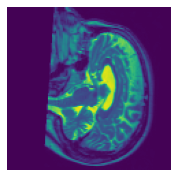

In [31]:
snf.show()

In [32]:
import pdb

In [52]:
tfm_pipe = Pipeline([NiftiTfm(), fastai.data.transforms.ToTensor()])
tfm_pipe.setup(fns)

In [131]:
tfm_pipe2 = Pipeline([NiftiTfm(), NumpyResizeRandomCrop((30,30,30)), NumpyToTensor()])
tfm_pipe2.setup(fns)



In [132]:
x,y = tfm_pipe(fns[0])

In [133]:
x.shape

(120, 120, 90)

In [134]:
y.shape

(120, 120, 90)

In [135]:
type(y) #not a tensor...

numpy.ndarray

In [136]:
x,y = tfm_pipe2(fns[0])

In [138]:
type(y), y.shape, x.shape

(torch.Tensor, torch.Size([30, 30, 30]), torch.Size([30, 30, 30]))

In [115]:
splits = RandomSplitter(seed=42)(fns)
tls = TfmdLists(fns, [NiftiTfm(), NumpyToTensor()], splits=splits)


In [41]:
splits

((#23) [10,20,12,18,4,14,16,9,7,15...], (#5) [22,24,8,17,0])

In [42]:
dls = tls.dataloaders(bs=12)

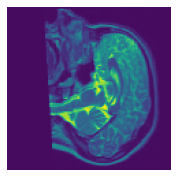

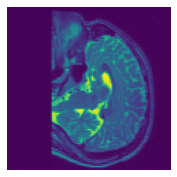

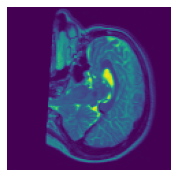

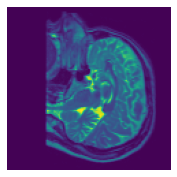

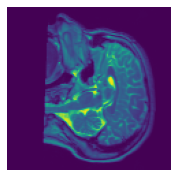

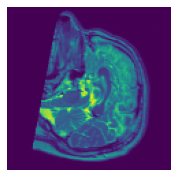

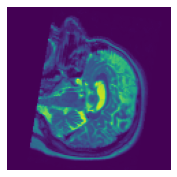

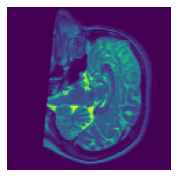

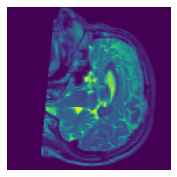

In [43]:
dls.show_batch()

### Transforms and DataBlocks experiments

In [7]:
mnist_src = untar_data(URLs.MNIST_TINY)/'train'


In [8]:
items = get_image_files(mnist_src)
fn = items[0]
img = PILImage.create(fn); img

In [9]:
tens_tfm = fastai.data.transforms.ToTensor()
t_img = tens_tfm(img); t_img

TensorImage([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

In [10]:
type(t_img)

fastai.torch_core.TensorImage

In [11]:
na = np.arange(96).reshape((1,2,3,4,4)); na

array([[[[[ 0,  1,  2,  3],
          [ 4,  5,  6,  7],
          [ 8,  9, 10, 11],
          [12, 13, 14, 15]],

         [[16, 17, 18, 19],
          [20, 21, 22, 23],
          [24, 25, 26, 27],
          [28, 29, 30, 31]],

         [[32, 33, 34, 35],
          [36, 37, 38, 39],
          [40, 41, 42, 43],
          [44, 45, 46, 47]]],


        [[[48, 49, 50, 51],
          [52, 53, 54, 55],
          [56, 57, 58, 59],
          [60, 61, 62, 63]],

         [[64, 65, 66, 67],
          [68, 69, 70, 71],
          [72, 73, 74, 75],
          [76, 77, 78, 79]],

         [[80, 81, 82, 83],
          [84, 85, 86, 87],
          [88, 89, 90, 91],
          [92, 93, 94, 95]]]]])

In [35]:
def test_me(): #if you wrap set_trace() in a function it's happy. If you don't it yells at you. 
    pdb.set_trace()
    tna = tens_tfm(na)


In [ ]:
test_me()

> <ipython-input-35-aa3e14986902>(3)test_me()
      1 def test_me(): #if you wrap set_trace() in a function it's happy. If you don't it yells at you.
      2     pdb.set_trace()
----> 3     tna = tens_tfm(na)

ipdb> s
--Call--
> /home/larsonte/anaconda3/envs/fastai-v2/lib/python3.8/site-packages/fastcore/transform.py(73)__call__()
     71     @property
     72     def name(self): return getattr(self, '_name', _get_name(self))
---> 73     def __call__(self, x, **kwargs): return self._call('encodes', x, **kwargs)
     74     def decode  (self, x, **kwargs): return self._call('decodes', x, **kwargs)
     75     def __repr__(self): return f'{self.name}:\nencodes: {self.encodes}decodes: {self.decodes}'

ipdb> s
> /home/larsonte/anaconda3/envs/fastai-v2/lib/python3.8/site-packages/fastcore/transform.py(73)__call__()
     71     @property
     72     def name(self): return getattr(self, '_name', _get_name(self))
---> 73     def __call__(self, x, **kwargs): return self._call('encodes', x, **kw

ipdb> s
--Call--
> /home/larsonte/anaconda3/envs/fastai-v2/lib/python3.8/site-packages/fastcore/dispatch.py(131)__get__()
    129         return f(*args, **kwargs)
    130 
--> 131     def __get__(self, inst, owner):
    132         self.inst = inst
    133         self.owner = owner

ipdb> p inst
ToTensor:
encodes: (PILMask,object) -> encodes
(PILBase,object) -> encodes
decodes: 
ipdb> p owner
<class 'fastai.data.transforms.ToTensor'>
ipdb> type(inst)
<class 'fastai.data.transforms.ToTensor'>
ipdb> inst
ToTensor:
encodes: (PILMask,object) -> encodes
(PILBase,object) -> encodes
decodes: 
ipdb> n
> /home/larsonte/anaconda3/envs/fastai-v2/lib/python3.8/site-packages/fastcore/dispatch.py(132)__get__()
    130 
    131     def __get__(self, inst, owner):
--> 132         self.inst = inst
    133         self.owner = owner
    134         return self

ipdb> n
> /home/larsonte/anaconda3/envs/fastai-v2/lib/python3.8/site-packages/fastcore/dispatch.py(133)__get__()
    131     def __get__(self,

ipdb> n
> /home/larsonte/anaconda3/envs/fastai-v2/lib/python3.8/site-packages/fastcore/transform.py(89)_do_call()
     87             if f is None: return x
     88             ret = f.returns_none(x) if hasattr(f,'returns_none') else None
---> 89             return retain_type(f(x, **kwargs), x, ret)
     90         res = tuple(self._do_call(f, x_, **kwargs) for x_ in x)
     91         return retain_type(res, x)

ipdb> u
> /home/larsonte/anaconda3/envs/fastai-v2/lib/python3.8/site-packages/fastcore/transform.py(83)_call()
     81     def _call(self, fn, x, split_idx=None, **kwargs):
     82         if split_idx!=self.split_idx and self.split_idx is not None: return x
---> 83         return self._do_call(getattr(self, fn), x, **kwargs)
     84 
     85     def _do_call(self, f, x, **kwargs):

ipdb> u
> /home/larsonte/anaconda3/envs/fastai-v2/lib/python3.8/site-packages/fastcore/transform.py(73)__call__()
     71     @property
     72     def name(self): return getattr(self, '_name', _



it looks like `TypeDispatch` has a role to play in handing this off in `fastcore/transform.py` `Transform._do_call()` has an f like

`---> 85     def _do_call(self, f, x, **kwargs):`

```
ipdb> p f
(PILMask,object) -> encodes
(PILBase,object) -> encodes
```

Note that...

```
self.encodes,self.decodes,self.setups = TypeDispatch(),TypeDispatch(),TypeDispatch()
```

This exists in `vision/core.py`

```
# Cell
@ToTensor
def encodes(self, o:PILBase): return o._tensor_cls(image2tensor(o))
@ToTensor
def encodes(self, o:PILMask): return o._tensor_cls(image2tensor(o)[0])
```


In [5]:
tensor

<function fastai.torch_core.tensor(x, *rest, dtype=None, device=None, requires_grad=False, pin_memory=False)>

In [14]:
tna2 = tensor(na)

In [21]:
type(tna2), tna2.shape, tna2.numpy().shape, type(tna2.numpy())


(torch.Tensor, torch.Size([1, 2, 3, 4, 4]), (1, 2, 3, 4, 4), numpy.ndarray)

In [25]:
#curious what this does...
tuple_na = tensor((na,na))
type(tuple_na), tuple_na.shape

(torch.Tensor, torch.Size([2, 1, 2, 3, 4, 4]))

In [ ]:
type(tna)


If you wanted to use ToTensor (who really cares) you could see if you can take a 3D image and use PILBase or something similar as a super class of your data type that you pass through the Tansform / Pipeline.  Doubt this will work but you miht learn something.